# Neural network for digit recognition using PyTorch

This notebook is a simple example of how to use PyTorch to build a neural network for digit recognition. The dataset used is the MNIST dataset, which is a dataset of 28x28 grayscale images of handwritten digits (0-9). The goal is to build a neural network that can recognize the digit in the image. 

It's an introductory notebook, that will help me to understand how to use PyTorch to build neural networks.

In [118]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

We'll first load the dataset and visualize some images.

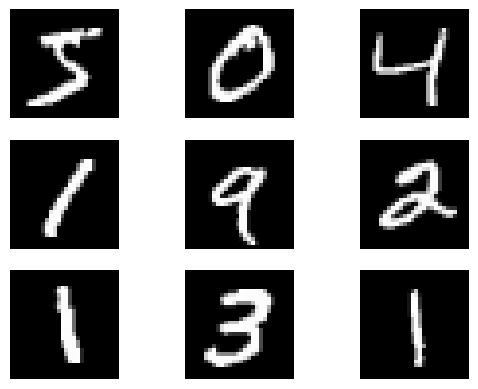

In [119]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()    
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()    
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# visualize some images by creating a grid of images
fig, ax = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(training_data[i * 3 + j][0].reshape(28, 28), cmap='gray')
        ax[i, j].axis('off')

plt.show()

## Creating the model

We'll create a simple neural network with two hidden layers. The input layer will have 784 neurons (28x28 pixels), the hidden layers will have 512 neurons, and the output layer will have 10 neurons (one for each digit). We'll use the ReLU activation function for the hidden layers and the softmax activation function for the output layer.

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear_relu_stack(x)
        return outputs
    
    
    def predict(self, x):
        outputs = self.forward(x)
        return torch.argmax(outputs, dim=1)
    

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


Now, we need to define an optimizer and a loss function. We'll use the SGD (Stochastic gradient descent) optimizer and the Mean Squared Error loss function.

In [121]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    training_losses = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        training_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return torch.mean(torch.tensor(training_losses))


def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    correct /= size
    test_loss /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct

In the end, we'll train the model and evaluate it using the test set.

In [122]:
epochs = 10
train_losses = []
accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    
    correct = test(test_dataloader, model)
    accuracies.append(correct)

    if correct > 0.95:
        break
    
print("Done!")

Epoch 1
-------------------------------
loss: 2.302143  [    0/60000]
loss: 2.297519  [ 6400/60000]
loss: 2.292451  [12800/60000]
loss: 2.217475  [19200/60000]
loss: 2.112689  [25600/60000]
loss: 1.930705  [32000/60000]
loss: 1.814062  [38400/60000]
loss: 1.792410  [44800/60000]
loss: 1.722193  [51200/60000]
loss: 1.662908  [57600/60000]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.026144 

Epoch 2
-------------------------------
loss: 1.650032  [    0/60000]
loss: 1.673621  [ 6400/60000]
loss: 1.684392  [12800/60000]
loss: 1.604445  [19200/60000]
loss: 1.642776  [25600/60000]
loss: 1.681296  [32000/60000]
loss: 1.607648  [38400/60000]
loss: 1.720073  [44800/60000]
loss: 1.649965  [51200/60000]
loss: 1.613231  [57600/60000]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.025536 

Epoch 3
-------------------------------
loss: 1.595361  [    0/60000]
loss: 1.654677  [ 6400/60000]
loss: 1.665314  [12800/60000]
loss: 1.595724  [19200/60000]
loss: 1.615844  [25600/60000]
loss: 1.681986  [32000/600

We'll finish by plotting the loss & accuracy curves, and some images along with their predictions.

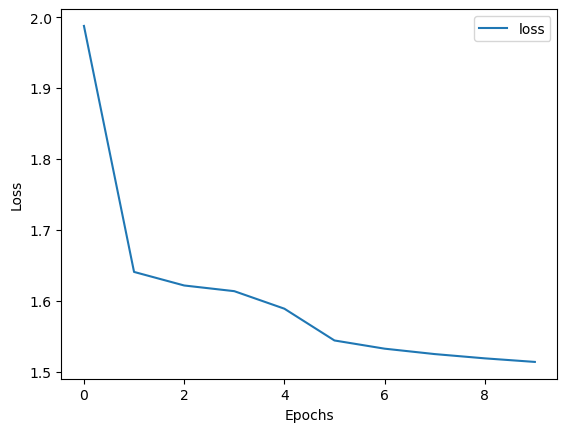

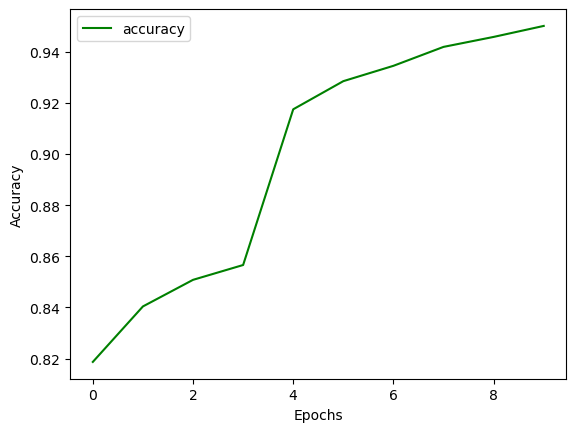

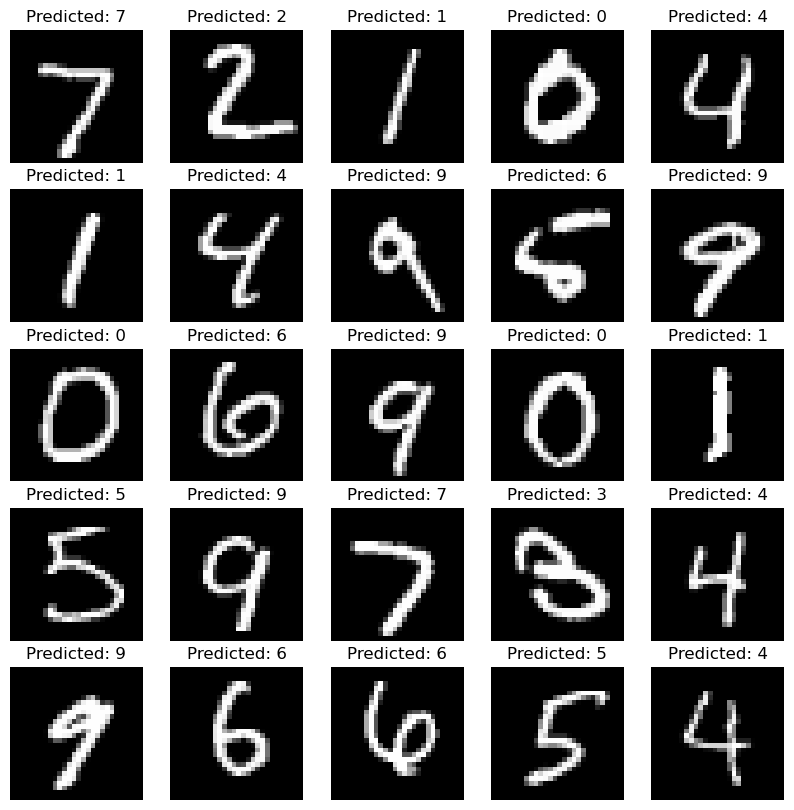

In [123]:
plot = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label='loss')
plt.legend()
plt.show()

plot = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracies, label='accuracy', color='green')
plt.legend()
plt.show()

fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        ax[i, j].imshow(test_data[i * 5 + j][0].reshape(28, 28), cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title(f"Predicted: {model.predict(test_data[i * 5 + j][0].reshape(1, 1, 28, 28).to(device)).item()}")

plt.show()